# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, desc, lit, min, max, split, udf, sum, when
from pyspark.sql.types import *
from datetime import datetime 
import time
import warnings
warnings.filterwarnings('ignore')
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.mllib.tree import DecisionTree

from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Predicting churn using Pyspark ML") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
events = spark.read.json('mini_sparkify_event_data.json')

#### Reading the top 5 records

In [12]:
events.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [6]:
#checking the first 5 rows from the dataset
#using pandas to print the dataframe in a more readable format
pd.DataFrame(events.take(5), columns=events.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


#### Readin the total number of records

In [13]:
events.count()

286500

In [9]:
#printing the column datatypes
events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [11]:
# Seeing the pages the user can see on his screen
pag = events.select('page').distinct()
printpag.head(100)

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [11]:
#Let's check if there are any missing sessionid's or not
events.where(col('sessionId').isNull()).count()

0

In [12]:
#Let's check if there are some missing userid's or not
events.where(col('userId').isNull()).distinct().count()

0

In [19]:
#Identifying userId which are blanks, mostly meaning guest users
print(events.where(col('userId') == '').count())

#Removing records having the user_id as blanks
valid_events = events.where(col('userId') != '')

8346


In [20]:
# Writing user defined functions to create the date time stamp 
get_timestamp = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [22]:
#applying the functions and creating 2 new columns
valid_events  = valid_events.withColumn("datetime", get_timestamp(events.ts))
pd.DataFrame(valid_events.take(50), columns=valid_events.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,datetime,hourofday
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16,0
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:11:18,0
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:14:46,0
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:14:59,0
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:15:05,0
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:18:04,0


In [23]:
#only keeping relevant columns for the analysis
events_subset = valid_events.select('sessionId','userId','artist','auth','gender','length','level','location','page','song','datetime', 'hourofday')

In [24]:
events_subset.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [25]:
# View 5 records having cancellation confirmation 
pd.DataFrame(valid_events.filter("page == 'Cancellation Confirmation'").take(5), columns = valid_events.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,datetime,hourofday
0,None,Cancelled,Adriel,M,104,Mendoza,None,paid,"Kansas City, MO-KS",GET,Cancellation Confirmation,1535623466000,514,None,200,1538943990000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18,2018-10-07 20:26:30,20
1,None,Cancelled,Diego,M,56,Mckee,None,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Cancellation Confirmation,1537167593000,540,None,200,1539033046000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32,2018-10-08 21:10:46,21
2,None,Cancelled,Mason,M,10,Hart,None,free,"Corpus Christi, TX",GET,Cancellation Confirmation,1533157139000,174,None,200,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,2018-10-12 04:35:18,4
3,None,Cancelled,Alexander,M,332,Garcia,None,paid,"Indianapolis-Carmel-Anderson, IN",GET,Cancellation Confirmation,1536817381000,508,None,200,1539375441000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,105,2018-10-12 20:17:21,20
4,None,Cancelled,Kayla,F,273,Johnson,None,paid,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",GET,Cancellation Confirmation,1538333829000,797,None,200,1539465584000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) G...,17,2018-10-13 21:19:44,21


In [26]:
# Count of userids having cancelled status not equal to null 
# Active users are those having page not equal to cancelled 
valid_events.filter("page != 'Cancellation Confirmation'").select('userId').distinct().count()

225

In [27]:
#Counting users having status as cancelled
valid_events.filter("page == 'Cancellation Confirmation'").select('userId').distinct().count()

52

In [28]:
#Creating a dataset for churned data
churned_events = valid_events.where('page == "Cancellation Confirmation"')

In [29]:
churned_events.select(['userId','artist','page','song', 'level','datetime']).show()

+------+------+--------------------+----+-----+-------------------+
|userId|artist|                page|song|level|           datetime|
+------+------+--------------------+----+-----+-------------------+
|    18|  null|Cancellation Conf...|null| paid|2018-10-07 20:26:30|
|    32|  null|Cancellation Conf...|null| paid|2018-10-08 21:10:46|
|   125|  null|Cancellation Conf...|null| free|2018-10-12 04:35:18|
|   105|  null|Cancellation Conf...|null| paid|2018-10-12 20:17:21|
|    17|  null|Cancellation Conf...|null| paid|2018-10-13 21:19:44|
|   143|  null|Cancellation Conf...|null| free|2018-10-15 07:34:14|
|   101|  null|Cancellation Conf...|null| paid|2018-10-16 22:30:37|
|   129|  null|Cancellation Conf...|null| paid|2018-10-17 00:29:21|
|   121|  null|Cancellation Conf...|null| paid|2018-10-17 07:02:29|
|    51|  null|Cancellation Conf...|null| paid|2018-10-17 07:39:32|
|    87|  null|Cancellation Conf...|null| paid|2018-10-20 15:49:16|
|   122|  null|Cancellation Conf...|null| paid|2

In [30]:
#let's create a churn flag column, where some user has already cancelled the services. In order to do the same we will first
#need to find out the users who churned from the system.
churned_users = valid_events.where(valid_events.auth=="Cancelled").select("userId").distinct()

#creating a list of users who churned
churned_users = [(row['userId']) for row in churned_users.collect()]

#assigning 1 to the event of churn, 0 otherwise.
valid_events_withchurn = valid_events.withColumn("churned", when(col("userId").isin(churned_users),1).otherwise(0))

In [31]:
valid_events_withchurn.count()

278154

In [32]:
# Validating if the churn data has been added or not
valid_events_withchurn.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- hourofday: string (nullable = true)
 |-- churned: integer (nullable = false)



In [33]:
# Getting the frequency count of churned column
valid_events_withchurn.select(['userId','churned']).distinct().groupBy('churned').count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      1|   52|
|      0|  173|
+-------+-----+



#### Identifying the hours of the day when the songs are played

In [34]:
songs_played_hour = valid_events_withchurn.filter("page == 'NextSong'").groupBy("hourofday").count().orderBy(valid_events_withchurn.hourofday.cast("integer"))

In [36]:
#converting to pandas for plotting
songs_played_hour = songs_played_hour.toPandas()
songs_played_hour

,hourofday,count
0,0,9062
1,1,8388
2,2,8336
3,3,8355
4,4,8147
5,5,8178
6,6,8054
7,7,8091
8,8,8253
9,9,8498


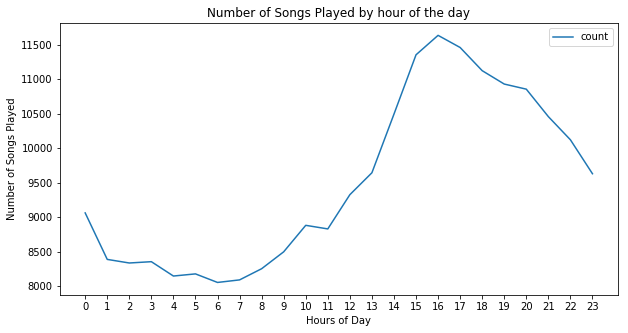

In [38]:
songs_played_hour.plot(kind = "line", figsize= (10,5))
plt.xticks(np.arange(0,24,1))
plt.xlabel("Hours of Day")
plt.ylabel("Number of Songs Played")
plt.title("Number of Songs Played by hour of the day")
plt.show()

In [39]:
# Getting the churned/ not churned users by genders
valid_events_withchurn.select(['userId', 'gender', 'churned']).distinct().groupBy(['churned','gender']).count().sort('churned').show()

+-------+------+-----+
|churned|gender|count|
+-------+------+-----+
|      0|     M|   89|
|      0|     F|   84|
|      1|     F|   20|
|      1|     M|   32|
+-------+------+-----+



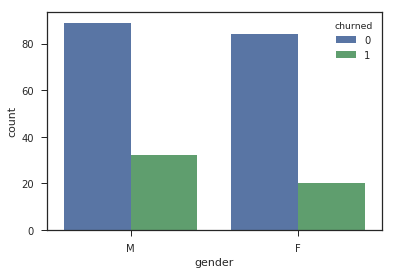

In [40]:
#Ploting the frequency in the bar chart
churned_gender = valid_events_withchurn.select(['userId', 'gender', 'churned']).distinct().groupBy(['churned','gender']).count().sort('churned').toPandas()
sns.set(style="ticks", color_codes=True)
sns.barplot(x="gender", y="count", hue="churned", data=churned_gender);

In [54]:
#checking the count for 2 different types
valid_events_withchurn.select(['userId', 'level', 'churned']).distinct().groupBy(['churned','level']).count().sort('churned').show()

+-------+-----+-----+
|churned|level|count|
+-------+-----+-----+
|      0| free|  149|
|      0| paid|  129|
|      1| paid|   36|
|      1| free|   46|
+-------+-----+-----+



In [55]:
#converting into a pandas dataframe
churned_levels= valid_events_withchurn.select(['userId', 'level', 'churned']).distinct().groupBy(['churned','level']).count().sort('churned').toPandas()

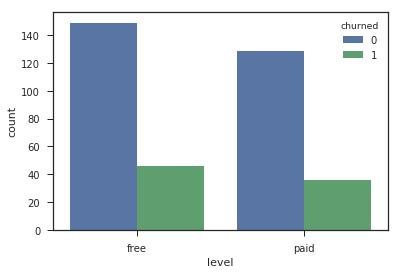

In [56]:
#plotting with seaborn
sns.set(style="ticks", color_codes=True)
sns.barplot(x="level", y="count", hue="churned", data=churned_levels);

In [57]:
#converting into a pandas dataframe
activity= valid_events_withchurn.select(['userId', 'sessionId', 'churned']).distinct().groupBy('churned').count().sort('churned').toPandas()
activity

,churned,count
0,0,2639
1,1,537


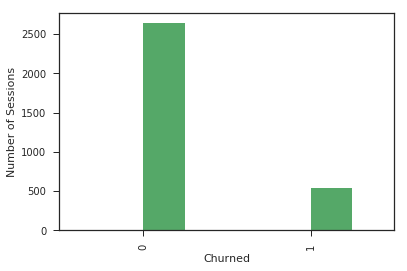

In [58]:
activity.plot(kind="bar", legend=False);
plt.xlabel("Churned")
plt.ylabel("Number of Sessions")
plt.show()

In [59]:
valid_events_withchurn.where('page="NextSong"').select(['userId', 'churned']).distinct().groupBy('churned').count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      1|   52|
|      0|  173|
+-------+-----+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [61]:
total_songs = valid_events_withchurn.filter("page == 'NextSong'").groupBy("userId").count()
total_songs = total_songs.withColumnRenamed('count', 'total_songs_played')
total_songs.show()

+------+------------------+
|userId|total_songs_played|
+------+------------------+
|100010|               275|
|200002|               387|
|   125|                 8|
|    51|              2111|
|   124|              4079|
|     7|               150|
|    54|              2841|
|    15|              1914|
|   155|               820|
|   132|              1928|
|   154|                84|
|100014|               257|
|   101|              1797|
|    11|               647|
|   138|              2070|
|300017|              3632|
|    29|              3028|
|    69|              1125|
|100021|               230|
|    42|              3573|
+------+------------------+
only showing top 20 rows



In [62]:
# Finding the minimum and maximum date for a user
date_user = valid_events_withchurn.select(['userId','datetime']).groupBy('userID').agg(min(col("datetime")).alias("min_date"), max(col("datetime")).alias("max_date") )
date_user.show()

+------+-------------------+-------------------+
|userID|           min_date|           max_date|
+------+-------------------+-------------------+
|100010|2018-10-08 12:58:54|2018-11-21 18:12:32|
|200002|2018-10-01 11:30:30|2018-11-15 23:25:54|
|   125|2018-10-12 04:05:44|2018-10-12 04:35:18|
|   124|2018-10-01 15:17:10|2018-11-30 15:12:46|
|    51|2018-10-01 12:57:12|2018-10-17 07:39:32|
|     7|2018-10-03 11:57:49|2018-11-23 06:46:51|
|    15|2018-10-01 10:23:35|2018-11-25 04:56:58|
|    54|2018-10-01 00:32:10|2018-11-12 19:40:08|
|   155|2018-11-02 15:56:25|2018-11-28 11:48:30|
|100014|2018-10-10 13:12:16|2018-11-20 19:04:09|
|   132|2018-10-02 08:59:56|2018-11-21 20:56:12|
|   154|2018-11-02 15:15:35|2018-11-27 14:56:05|
|   101|2018-10-01 01:50:05|2018-10-16 22:30:37|
|    11|2018-10-05 03:20:29|2018-11-27 09:08:22|
|   138|2018-10-05 22:08:54|2018-11-30 23:59:25|
|300017|2018-10-01 13:14:06|2018-11-29 15:58:07|
|100021|2018-10-11 00:04:35|2018-11-25 11:03:02|
|    29|2018-10-01 2

In [63]:
# Calculating the tenure of the user  (Max Date - Min Date)
date_user = date_user.withColumn("total_number_of_days", F.datediff(col("max_date"), col("min_date")))
date_user.sort("total_number_of_days", ascending=False).show()

+------+-------------------+-------------------+--------------------+
|userID|           min_date|           max_date|total_number_of_days|
+------+-------------------+-------------------+--------------------+
|300011|2018-10-01 21:48:13|2018-12-01 00:00:11|                  61|
|     9|2018-10-01 00:03:00|2018-11-30 14:19:12|                  60|
|200023|2018-10-01 11:37:50|2018-11-30 22:35:49|                  60|
|    81|2018-10-01 16:41:46|2018-11-30 23:56:13|                  60|
|    93|2018-10-01 15:48:39|2018-11-30 23:43:25|                  60|
|    38|2018-10-01 20:18:36|2018-11-30 19:33:21|                  60|
|   140|2018-10-01 15:02:07|2018-11-30 19:33:12|                  60|
|    92|2018-10-01 12:41:10|2018-11-30 23:34:25|                  60|
|300015|2018-10-01 19:17:53|2018-11-30 16:53:06|                  60|
|   120|2018-10-01 11:29:39|2018-11-30 01:08:23|                  60|
|    95|2018-10-01 04:21:42|2018-11-30 15:27:24|                  60|
|    30|2018-10-01 0

In [64]:
# Creating a table having userId, total number of songs played and tenure of the user
features = total_songs.join(date_user.select(['userId','total_number_of_days']),on = 'userId', how = 'inner')
features.show()

+------+------------------+--------------------+
|userId|total_songs_played|total_number_of_days|
+------+------------------+--------------------+
|100010|               275|                  44|
|200002|               387|                  45|
|   125|                 8|                   0|
|    51|              2111|                  16|
|   124|              4079|                  60|
|     7|               150|                  51|
|    54|              2841|                  42|
|    15|              1914|                  55|
|   155|               820|                  26|
|   132|              1928|                  50|
|   154|                84|                  25|
|100014|               257|                  41|
|   101|              1797|                  15|
|    11|               647|                  53|
|   138|              2070|                  56|
|300017|              3632|                  59|
|    29|              3028|                  44|
|    69|            

In [65]:
# Calculating the average length by users
avg_session_length_df = valid_events_withchurn.select(['userId', 'length']).distinct().groupBy("userId").agg(avg("length").alias("avg_session_length"))
avg_session_length_df.show()

+------+------------------+
|userId|avg_session_length|
+------+------------------+
|100010|243.28376220149258|
|200002| 243.8535182037533|
|   125|261.13913750000006|
|   124| 250.7709492796006|
|    51|247.92487476446036|
|     7| 251.1926630405405|
|    15|251.10429575776783|
|    54|  251.978400607917|
|   155|240.49622712737127|
|   132|251.74449363344056|
|100014| 261.8860570661157|
|   154|247.27114390243895|
|   101|248.88575961643838|
|    11| 246.2084100000001|
|   138|249.05871161486903|
|300017| 249.7192652406623|
|    29|251.21818720248686|
|    69|253.56698054192233|
|100021|250.64712642857143|
|    42|248.87731689601864|
+------+------------------+
only showing top 20 rows



In [66]:
# Joining it to the features table
features = features.join(avg_session_length_df.select(['userId','avg_session_length']),on = 'userId', how = 'inner')
features.show()

+------+------------------+--------------------+------------------+
|userId|total_songs_played|total_number_of_days|avg_session_length|
+------+------------------+--------------------+------------------+
|100010|               275|                  44|243.28376220149258|
|200002|               387|                  45| 243.8535182037533|
|   125|                 8|                   0|261.13913750000006|
|   124|              4079|                  60| 250.7709492796006|
|    51|              2111|                  16|247.92487476446036|
|     7|               150|                  51| 251.1926630405405|
|    15|              1914|                  55|251.10429575776783|
|    54|              2841|                  42|  251.978400607917|
|   155|               820|                  26|240.49622712737127|
|100014|               257|                  41| 261.8860570661157|
|   132|              1928|                  50|251.74449363344056|
|   154|                84|                  25|

In [67]:
# Calculating the average songs per user
user_session_songs = valid_events_withchurn.where(valid_events_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
avg_session_songs_user_df = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avg_session_songs_user"))
avg_session_songs_user_df.show()

+------+----------------------+
|userId|avg_session_songs_user|
+------+----------------------+
|100010|    39.285714285714285|
|200002|                  64.5|
|   125|                   8.0|
|    51|                 211.1|
|   124|    145.67857142857142|
|     7|    21.428571428571427|
|    54|     81.17142857142858|
|    15|    136.71428571428572|
|   155|    136.66666666666666|
|100014|    42.833333333333336|
|   132|                 120.5|
|   154|                  28.0|
|   101|                 179.7|
|    11|               40.4375|
|300017|    59.540983606557376|
|   138|                 138.0|
|    29|     89.05882352941177|
|    69|                 125.0|
|100021|                  46.0|
|    42|     87.14634146341463|
+------+----------------------+
only showing top 20 rows



In [68]:
# Joining it to the features table
features = features.join(avg_session_songs_user_df.select(['userId','avg_session_songs_user']),on = 'userId', how = 'inner')
features.show()

+------+------------------+--------------------+------------------+----------------------+
|userId|total_songs_played|total_number_of_days|avg_session_length|avg_session_songs_user|
+------+------------------+--------------------+------------------+----------------------+
|100010|               275|                  44|243.28376220149258|    39.285714285714285|
|200002|               387|                  45| 243.8535182037533|                  64.5|
|   125|                 8|                   0|261.13913750000006|                   8.0|
|   124|              4079|                  60| 250.7709492796006|    145.67857142857142|
|    51|              2111|                  16|247.92487476446036|                 211.1|
|     7|               150|                  51| 251.1926630405405|    21.428571428571427|
|    15|              1914|                  55|251.10429575776783|    136.71428571428572|
|    54|              2841|                  42|  251.978400607917|     81.17142857142858|

In [69]:
# Creating a table at user id level to count the likes and dislikes
like_activity_df = valid_events_withchurn.where(valid_events_withchurn.page=="Thumbs Up").groupby("userId").count()
like_activity_df = like_activity_df.withColumnRenamed('count', 'total_number_of_likes')

dislike_activity_df = valid_events_withchurn.where(valid_events_withchurn.page=="Thumbs Down").groupby("userId").count()
dislike_activity_df = dislike_activity_df.withColumnRenamed('count', 'total_number_of_dislikes')

activities = like_activity_df.join(dislike_activity_df, on ='userId', how = 'inner')
activities.show()

+------+---------------------+------------------------+
|userId|total_number_of_likes|total_number_of_dislikes|
+------+---------------------+------------------------+
|100010|                   17|                       5|
|200002|                   21|                       6|
|   124|                  171|                      41|
|    51|                  100|                      21|
|     7|                    7|                       1|
|    15|                   81|                      14|
|    54|                  163|                      29|
|   155|                   58|                       3|
|100014|                   17|                       3|
|   132|                   96|                      17|
|   101|                   86|                      16|
|    11|                   40|                       9|
|   138|                   95|                      24|
|300017|                  303|                      28|
|100021|                   11|                  

In [70]:
# Compute the average number of songs/ session each user listens to
user_session_songs = valid_events_withchurn.where(valid_events_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
avg_session_songs_user_df = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avg_session_songs_user"))

In [71]:
#joining with features dataset
features = features.join(activities.select(['userId', 'total_number_of_likes', 'total_number_of_dislikes']), on ='userId', how='inner')
features.show()

+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+
|userId|total_songs_played|total_number_of_days|avg_session_length|avg_session_songs_user|total_number_of_likes|total_number_of_dislikes|
+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+
|100010|               275|                  44|243.28376220149258|    39.285714285714285|                   17|                       5|
|200002|               387|                  45| 243.8535182037533|                  64.5|                   21|                       6|
|   124|              4079|                  60| 250.7709492796006|    145.67857142857142|                  171|                      41|
|    51|              2111|                  16|247.92487476446036|                 211.1|                  100|                      21|
|     7|               150|       

In [72]:
added_to_playlist_df = valid_events_withchurn.where(valid_events_withchurn.page=="Add to Playlist").groupby("userId").count()
added_to_playlist_df = added_to_playlist_df.withColumnRenamed('count', 'total_songs_added_to_playlist')
added_to_playlist_df.show()

+------+-----------------------------+
|userId|total_songs_added_to_playlist|
+------+-----------------------------+
|100010|                            7|
|200002|                            8|
|    51|                           52|
|   124|                          118|
|     7|                            5|
|    15|                           59|
|    54|                           72|
|   155|                           24|
|   132|                           38|
|   154|                            1|
|100014|                            7|
|   101|                           61|
|    11|                           20|
|   138|                           67|
|300017|                          113|
|    29|                           89|
|    69|                           33|
|100021|                            7|
|    42|                          104|
|   112|                            7|
+------+-----------------------------+
only showing top 20 rows



In [73]:
#joining with features dataset
features = features.join(added_to_playlist_df.select(['userId','total_songs_added_to_playlist']),on = 'userId', how = 'inner')
features.show()

+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+
|userId|total_songs_played|total_number_of_days|avg_session_length|avg_session_songs_user|total_number_of_likes|total_number_of_dislikes|total_songs_added_to_playlist|
+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+
|100010|               275|                  44|243.28376220149258|    39.285714285714285|                   17|                       5|                            7|
|200002|               387|                  45| 243.8535182037533|                  64.5|                   21|                       6|                            8|
|   124|              4079|                  60| 250.7709492796006|    145.67857142857142|                  171|                      41|                       

In [74]:
#Adding the churned flag to the dataset
df_churned = valid_events_withchurn.select(['userId', 'churned']).distinct()
df_churned.show()

+------+-------+
|userId|churned|
+------+-------+
|    19|      0|
|100005|      1|
|200007|      0|
|300007|      1|
|    50|      0|
|200002|      0|
|    30|      0|
|     8|      0|
|100011|      1|
|100012|      1|
|     4|      0|
|    65|      0|
|   101|      1|
|    13|      0|
|   153|      0|
|    42|      0|
|100014|      1|
|    94|      0|
|    62|      0|
|   114|      0|
+------+-------+
only showing top 20 rows



In [122]:
#adding with the features dataset
features_with_label = features.join(df_churned, on ='userId', how ='inner')
features_with_label.show(1)

+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+-------+
|userId|total_songs_played|total_number_of_days|avg_session_length|avg_session_songs_user|total_number_of_likes|total_number_of_dislikes|total_songs_added_to_playlist|churned|
+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+-------+
|100010|               275|                  44|243.28376220149258|    39.285714285714285|                   17|                       5|                            7|      0|
+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+-------+
only showing top 1 row



In [76]:
# Convert all the variables into float

def convertColumn(df, names, newType):
    for name in names:
        df = df.withColumn(name, df[name].cast(newType))
    return df 

# Assign all column names to `columns`
columns = features_with_label.columns[1:]

# Conver the `df` columns to `FloatType()`
features_with_label = convertColumn(features_with_label, columns, FloatType())

In [77]:
features_with_label.show()

+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+-------+
|userId|total_songs_played|total_number_of_days|avg_session_length|avg_session_songs_user|total_number_of_likes|total_number_of_dislikes|total_songs_added_to_playlist|churned|
+------+------------------+--------------------+------------------+----------------------+---------------------+------------------------+-----------------------------+-------+
|100010|             275.0|                44.0|         243.28377|             39.285713|                 17.0|                     5.0|                          7.0|    0.0|
|200002|             387.0|                45.0|         243.85352|                  64.5|                 21.0|                     6.0|                          8.0|    0.0|
|   124|            4079.0|                60.0|         250.77095|             145.67857|                171.0|        

In [78]:
features_with_label.printSchema()

root
 |-- userId: string (nullable = true)
 |-- total_songs_played: float (nullable = false)
 |-- total_number_of_days: float (nullable = true)
 |-- avg_session_length: float (nullable = true)
 |-- avg_session_songs_user: float (nullable = true)
 |-- total_number_of_likes: float (nullable = false)
 |-- total_number_of_dislikes: float (nullable = false)
 |-- total_songs_added_to_playlist: float (nullable = false)
 |-- churned: float (nullable = false)



In [79]:
list_features = features_with_label.columns[1:]

In [80]:
features_df = features_with_label.select(list_features).toPandas()

In [81]:
# Wrinting a function to plot the graph of distributions

def distribution(data, list_features):
    """
    Visualization code for displaying distributions of features
    """
    
    # Create figure
    fig = plt.figure(figsize = (12,16));

    # Skewed feature plotting
    for i, feature in enumerate(list_features):
        ax = fig.add_subplot(4, 2, i+1)
        ax.hist(data[feature], bins = 25, color = '#00A0A0')
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")

    # Plot aesthetics
    fig.suptitle("Distributions of Continuous  Data Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

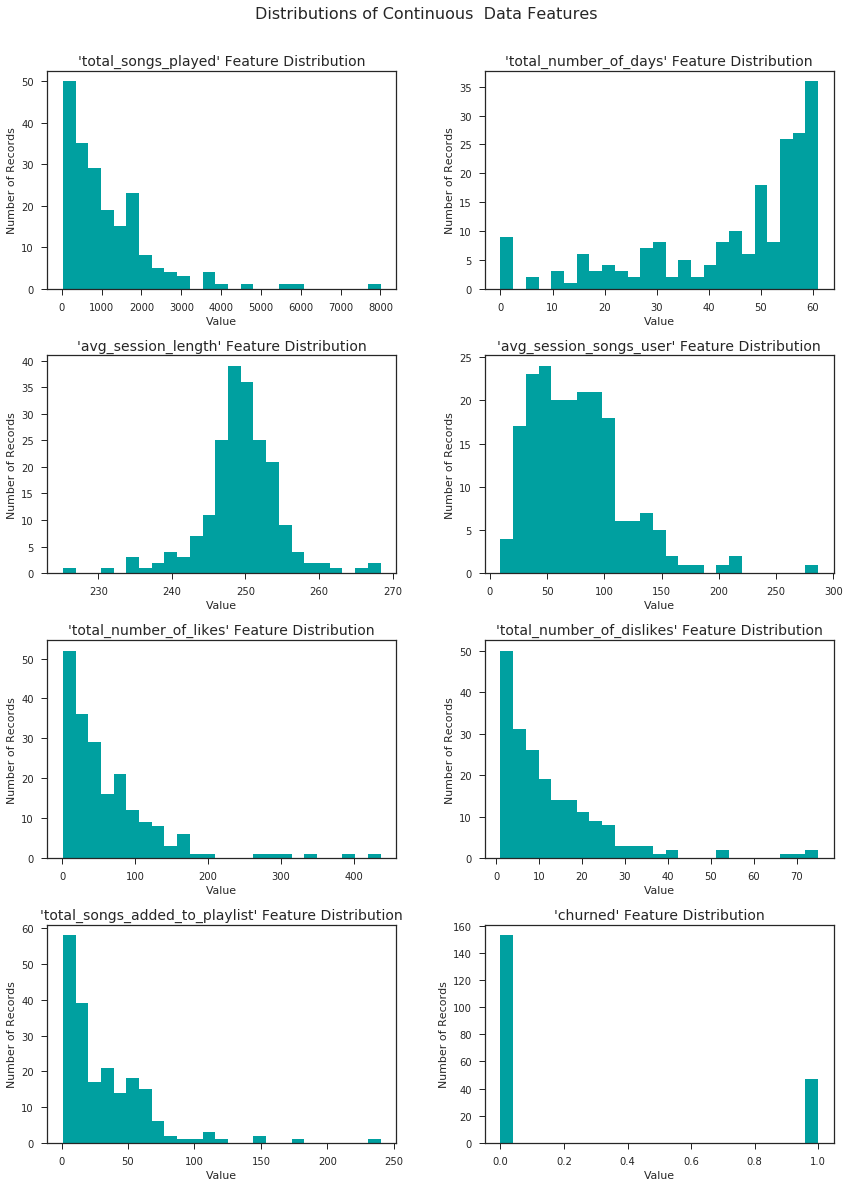

In [82]:
distribution(features_df, list_features)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [86]:
#we will define our feature columns next
features_col = ["total_songs_played", "total_number_of_days", "avg_session_length", "avg_session_songs_user", "total_number_of_likes", \
                "total_number_of_dislikes", "total_songs_added_to_playlist"]

In [87]:
def feature_transform(data):
    '''
        This function will take the input data with continuous features, and first will apply VectorAssembler and then
        will apply StandardScaler to normalize the data set. 
        Function will return the dataframe with new column added as scaledFeatures as a vector.
    '''
    #initializing the assembler and transforming the data
    assembler = VectorAssembler(inputCols=features_col, outputCol="features_vector")
    
    #VectorAssembler will assemble all our features into a vector, and we will pass
    #that vector to our model for making prediction.
    features_vectored = assembler.transform(features_with_label)
    
    #initializing the standardscaler and then transforming data and creating a new column, scaledFeatures
    scaler = StandardScaler(inputCol="features_vector", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
    scalerModel = scaler.fit(features_vectored)
    df_scaled = scalerModel.transform(features_vectored)
    print("Transformed dataframe")
    df_scaled.printSchema()
    
    return df_scaled

In [88]:
df_scaled = feature_transform(features_with_label)

Transformed dataframe
root
 |-- userId: string (nullable = true)
 |-- total_songs_played: float (nullable = false)
 |-- total_number_of_days: float (nullable = true)
 |-- avg_session_length: float (nullable = true)
 |-- avg_session_songs_user: float (nullable = true)
 |-- total_number_of_likes: float (nullable = false)
 |-- total_number_of_dislikes: float (nullable = false)
 |-- total_songs_added_to_playlist: float (nullable = false)
 |-- churned: float (nullable = false)
 |-- features_vector: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)



In [89]:
df_scaled.head(1)

[Row(userId='100010', total_songs_played=275.0, total_number_of_days=44.0, avg_session_length=243.2837677001953, avg_session_songs_user=39.28571319580078, total_number_of_likes=17.0, total_number_of_dislikes=5.0, total_songs_added_to_playlist=7.0, churned=0.0, features_vector=DenseVector([275.0, 44.0, 243.2838, 39.2857, 17.0, 5.0, 7.0]), scaledFeatures=DenseVector([0.2463, 2.5782, 45.1153, 0.9502, 0.2552, 0.3781, 0.211]))]

In [90]:
df_scaled.select(['features_vector', 'scaledFeatures']).show()

+--------------------+--------------------+
|     features_vector|      scaledFeatures|
+--------------------+--------------------+
|[275.0,44.0,243.2...|[0.24625383230211...|
|[387.0,45.0,243.8...|[0.34654630218515...|
|[4079.0,60.0,250....|[3.65261593440120...|
|[2111.0,16.0,247....|[1.89033396359915...|
|[150.0,51.0,251.1...|[0.13432027216479...|
|[1914.0,55.0,251....|[1.71392667282272...|
|[2841.0,42.0,251....|[2.54402595480113...|
|[820.0,26.0,240.4...|[0.73428415450085...|
|[257.0,41.0,261.8...|[0.23013539964234...|
|[1928.0,50.0,251....|[1.72646323155810...|
|[1797.0,15.0,248....|[1.60915686053419...|
|[647.0,53.0,246.2...|[0.57936810727079...|
|[2070.0,56.0,249....|[1.85361975587411...|
|[3632.0,59.0,249....|[3.25234152335013...|
|[230.0,45.0,250.6...|[0.20595775065267...|
|[3028.0,44.0,251....|[2.71147856076657...|
|[1125.0,51.0,253....|[1.00740204123592...|
|[215.0,57.0,248.5...|[0.19252572343619...|
|[3573.0,60.0,248....|[3.19950888296531...|
|[377.0,21.0,251.7...|[0.3375916

In [91]:
# Creating the final modeling dataset
df_final = df_scaled.select(['scaledFeatures', 'churned'])

In [92]:
#splitting the data into train and test using random split
train_data , test_data = df_scaled.randomSplit([0.8,0.2], seed = 42)
train_data.head(1)

[Row(userId='100010', total_songs_played=275.0, total_number_of_days=44.0, avg_session_length=243.2837677001953, avg_session_songs_user=39.28571319580078, total_number_of_likes=17.0, total_number_of_dislikes=5.0, total_songs_added_to_playlist=7.0, churned=0.0, features_vector=DenseVector([275.0, 44.0, 243.2838, 39.2857, 17.0, 5.0, 7.0]), scaledFeatures=DenseVector([0.2463, 2.5782, 45.1153, 0.9502, 0.2552, 0.3781, 0.211]))]

In [93]:
def train(classifier, train_data=train_data):
    ''' function will take as input the classifier name and return the trained model, results, along with training time 
        lr : LogisticRegression()
        rf : RandomForestClassifier()
        dt : DecisionTreeClassifier()
    
    '''
    if classifier == 'lr':
        #initializing logistic Regression for classification.
        print("Training the Logistic Regression Model...")
        start_time = time.time()
        lr = LogisticRegression(featuresCol ='scaledFeatures', labelCol = 'churned')
        
        #fitting the model
        model = lr.fit(train_data)
        
        training_time = (time.time() - start_time)
        print("That took %s seconds." % (time.time() - start_time))
        
    elif classifier == 'rf':
        #initializing the Random Forest Classifier
        print("Training the Random Forest Model...")
        start_time = time.time()
        rf = RandomForestClassifier(featuresCol = 'scaledFeatures', labelCol = 'churned')
        
        #fitting the model
        model = rf.fit(train_data)
        
        training_time = (time.time() - start_time)
        print("That took %s seconds." % (time.time() - start_time))
        
    elif classifier == 'dt':
        #initializing the Decision Tree Classifier
        print("Training the Decision Tree Model...")
        start_time = time.time()
        dt = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'churned')
        
        #fitting the model
        model = dt.fit(train_data)

        training_time = (time.time() - start_time)
        print("That took %s seconds." % (time.time() - start_time))
        
    elif classifier == 'gbt':
        #initializing the Gradient Boosted Tree Classifier
        print("Training the GBTClassifier Model...")
        start_time = time.time()
        dt = GBTClassifier(featuresCol = 'scaledFeatures', labelCol = 'churned')
        
        #fitting the model
        model = dt.fit(train_data)

        training_time = (time.time() - start_time)
        print("That took %s seconds." % (time.time() - start_time))
    
    else:
        print("Classifier not found. Please enter rf, lr, dt or gbt")
        
        
    return model, training_time

In [94]:
def test(model, test_data = test_data):
    '''
        This function will take as input the trained model, and do some predictions on the data, and return the 
        accuracy, areaUnderROC
    
    '''
    print("Testing model....")
    print("Statistics for model: {} ".format(model.featuresCol.parent.split('_')[0]))
    predictions = model.transform(test_data)
    
    #getting the area under ROC
    evaluator_areaUnderROC = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='churned', metricName='areaUnderROC')
    areaUnderROC = evaluator_areaUnderROC.evaluate(predictions)
    print("Test Area Under ROC: " + str(areaUnderROC))
    print("Test Error = %g" % (1.0 - areaUnderROC))
    
    return predictions, areaUnderROC

In [95]:
#training the Logistic Regression Model
model_lr, train_time = train('lr')

Training the Logistic Regression Model...
That took 251.92973566055298 seconds.


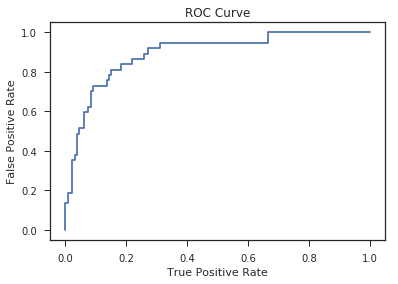

Training set areaUnderROC: 0.8923013923013933


In [96]:
#plotting the area under curve ROC for logistic regression. The roc is available in training summary.
training_summary = model_lr.summary
roc = training_summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(training_summary.areaUnderROC))

In [97]:
#testing and finding statistics about the models
predictions, areaUnderROC = test(model_lr)

Testing model....
Statistics for model: LogisticRegression 
Test Area Under ROC: 0.75
Test Error = 0.25


In [98]:
predictions.printSchema()

root
 |-- userId: string (nullable = true)
 |-- total_songs_played: float (nullable = false)
 |-- total_number_of_days: float (nullable = true)
 |-- avg_session_length: float (nullable = true)
 |-- avg_session_songs_user: float (nullable = true)
 |-- total_number_of_likes: float (nullable = false)
 |-- total_number_of_dislikes: float (nullable = false)
 |-- total_songs_added_to_playlist: float (nullable = false)
 |-- churned: float (nullable = false)
 |-- features_vector: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



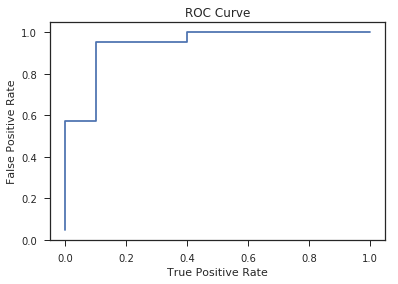

Testing set areaUnderROC: 0.75


In [99]:
#plotting the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# View model's predictions and probabilities of each prediction class
results = predictions.select(['probability', 'churned'])
#prepare score - label set
results_collect = results.collect()
results_list = [ (float(row[0][0]),1.0 - float(row[1]) ) for row in results_collect]

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr , _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Testing set areaUnderROC: ' + str(areaUnderROC))

In [100]:
#training the decision tree classifier
model_dt, train_time = train('dt')

Training the Decision Tree Model...
That took 90.92836356163025 seconds.


In [101]:
#testing and finding statistics about the models
predictions, areaUnderROC = test(model_dt)

Testing model....
Statistics for model: DecisionTreeClassifier 
Test Area Under ROC: 0.7761904761904761
Test Error = 0.22381


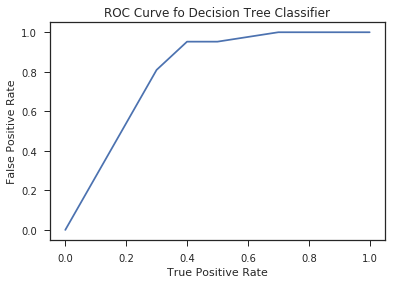

Testing set areaUnderROC: 0.7761904761904761


In [102]:
#plotting the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# View model's predictions and probabilities of each prediction class
results = predictions.select(['probability', 'churned'])
#prepare score - label set
results_collect = results.collect()
results_list = [ (float(row[0][0]),1.0 - float(row[1]) ) for row in results_collect]

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr , _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve fo Decision Tree Classifier')
plt.show()
print('Testing set areaUnderROC: ' + str(areaUnderROC))

In [103]:
#training the random forest classifier
model_rf, train_time = train('rf')

Training the Random Forest Model...
That took 107.42295718193054 seconds.


In [106]:
#saving the model
model_rf.save('models/model_rf_3.model')

In [107]:
#testing and finding statistics about the models
predictions, areaUnderROC = test(model_rf)

Testing model....
Statistics for model: RandomForestClassifier 
Test Area Under ROC: 0.8261904761904761
Test Error = 0.17381


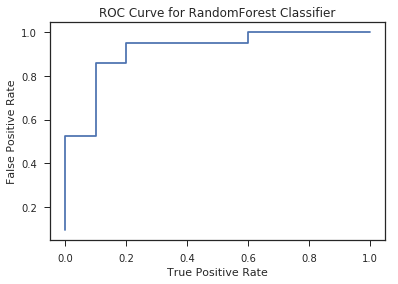

Testing set areaUnderROC: 0.8261904761904761


In [108]:
#plotting the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# View model's predictions and probabilities of each prediction class
results = predictions.select(['probability', 'churned'])
#prepare score - label set
results_collect = results.collect()
results_list = [ (float(row[0][0]),1.0 - float(row[1]) ) for row in results_collect]

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr , _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for RandomForest Classifier')
plt.show()
print('Testing set areaUnderROC: ' + str(areaUnderROC))

In [109]:
#training the gradient boosting classifier
model_gbt, train_time = train('gbt')

Training the GBTClassifier Model...
That took 337.8328626155853 seconds.


In [110]:
#testing and finding statistics about the models
predictions, areaUnderROC = test(model_gbt)

Testing model....
Statistics for model: GBTClassifier 
Test Area Under ROC: 0.7761904761904761
Test Error = 0.22381


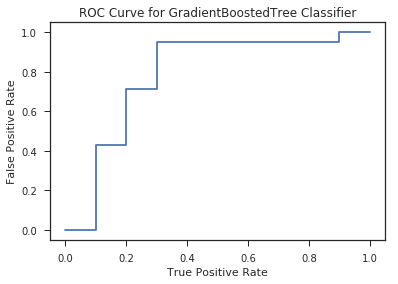

Testing set areaUnderROC: 0.7761904761904761


In [111]:
#plotting the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# View model's predictions and probabilities of each prediction class
results = predictions.select(['probability', 'churned'])
#prepare score - label set
results_collect = results.collect()
results_list = [ (float(row[0][0]),1.0 - float(row[1]) ) for row in results_collect]

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr , _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for GradientBoostedTree Classifier')
plt.show()
print('Testing set areaUnderROC: ' + str(areaUnderROC))

In [112]:
importantecs = model_rf.featureImportances

In [113]:
indices = np.argsort(importantecs)[::-1]

In [114]:
#the feature importance is
for i, c in enumerate(np.array(train_data.columns)):
    if i in indices and i > 0:
        print(i,c)

1 total_songs_played
2 total_number_of_days
3 avg_session_length
4 avg_session_songs_user
5 total_number_of_likes
6 total_number_of_dislikes


In [115]:
#in order to use in cross validation, we need to rename our target and features to a label, features. Same for test set.
train_data_cv = train_data.withColumnRenamed("churned", "label").withColumnRenamed("scaledFeatures", 'features')

In [116]:
test_data_cv = test_data.withColumnRenamed("churned", "label").withColumnRenamed("scaledFeatures", 'features')

In [117]:
#Random Forest Classifier
#we will now create a pipeline for estimator wrapping it in a CrossValidator instance.
# This will allow us to jointly choose parameters for all Pipeline stages.
# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# We use a ParamGridBuilder to construct a grid of parameters to search over.
# With 3 values for rf.numTrees and 4 values for rf.maxDepth,
# this grid will have 2 x 3 = 8 parameter settings for CrossValidator to choose from for 3 folds.

numFolds = 3

rf = RandomForestClassifier()
evaluator = BinaryClassificationEvaluator()  

paramGrid = (ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20])\
    .addGrid(rf.maxDepth, [2, 4, 6])  \
    .build())

crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

print("Training the RF over crossval...")
start_time = time.time()

model_rf_cv = crossval.fit(train_data_cv)

print("training complete")
print("That took %s seconds." % (time.time() - start_time))

Training the RF over crossval...
training complete
That took 683.2368428707123 seconds.


In [118]:
def cross_val_test(model, test_data = test_data_cv):
    '''
        This function will take as input the trained model, and do some predictions on the data, and return the 
        accuracy, areaUnderROC
    
    '''
    print("Testing model for cross validation....")
    predictions = model.transform(test_data_cv)
    
    #getting the area under ROC
    evaluator_areaUnderROC = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')
    areaUnderROC = evaluator_areaUnderROC.evaluate(predictions)
    print("Test Area Under ROC: " + str(areaUnderROC))
    print("Test Error = %g" % (1.0 - areaUnderROC))
    
    return predictions, areaUnderROC

In [119]:
# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction, areaUnderROC = cross_val_test(model_rf_cv)

Testing model for cross validation....
Test Area Under ROC: 0.8261904761904761
Test Error = 0.17381


In [120]:
model_rf_cv.bestModel

RandomForestClassificationModel (uid=RandomForestClassifier_3477a3d66c09) with 20 trees

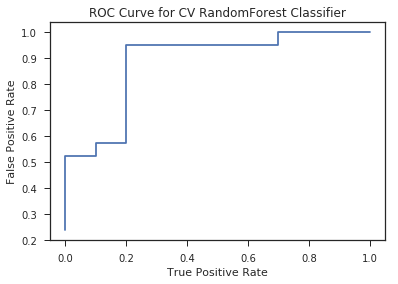

Testing set areaUnderROC: 0.8261904761904761


In [121]:
#plotting the AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

# View model's predictions and probabilities of each prediction class
results = prediction.select(['probability', 'label'])
#prepare score - label set
results_collect = results.collect()
results_list = [ (float(row[0][0]),1.0 - float(row[1]) ) for row in results_collect]

y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]

fpr, tpr , _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for CV RandomForest Classifier')
plt.show()
print('Testing set areaUnderROC: ' + str(areaUnderROC))

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.